## SVM ModelFactory

In [2]:
#libraries for modeling
from multiprocessing.pool import ThreadPool
from pyspark import SparkContext
from pyspark.sql import SQLContext, SparkSession, Window, Row
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator
import pyspark.sql.functions as F
import itertools
from itertools import repeat
import pickle
import pyspark
import copy

from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import LinearSVC
from pyspark.mllib.evaluation import MulticlassMetrics

#libraries for plotting
import matplotlib.gridspec as gridspec
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

class CreateBestModel:
    def __init__(self, algo, avgprecision, avgrecall, avgfscore, hyperparams, ootmodel, ootprecision, ootrecall, ootfscore):
        self.algo = algo
        self.gsPrecision = avgprecision
        self.gsFScore = avgfscore
        self.gsRecall = avgrecall
        self.hyperParams = hyperparams
        self.model = ootmodel
        self.ootPrecision = ootprecision
        self.ootFScore = ootfscore
        self.ootRecall = ootrecall

#function-based
def sample(df, sampling_method, ratio):

    notfraud = df.select('*').where(df.Class == 0.0)
    fraud = df.select('*').where(df.Class == 1.0)

    if sampling_method == "over":
        nrows = notfraud.select("Class").count()
        sample_size = int(nrows*ratio/(1-ratio))
        sampled = fraud.rdd.takeSample(True, sample_size, 46)
        fraud = sqlContext.createDataFrame(sampled)

    elif sampling_method == "under":
        nrows = fraud.select("Class").count()
        sample_size = int(nrows*(1-ratio)/ratio)
        sampled = notfraud.rdd.takeSample(False, sample_size, 46)
        notfraud = sqlContext.createDataFrame(sampled)
    else:
        return df
    
    sampled = fraud.union(notfraud)

    #shuffle undersampled dataframe
    nrows = sampled.select("Class").count()
    shuffled = sampled.rdd.takeSample(False, nrows, 46)
    shuffled_df = sqlContext.createDataFrame(shuffled)

    return shuffled_df

def generateParamGrid(*args):
    
    grid = list(itertools.product(*args))
    return grid

def generateClassifier(algo, params, features):

    ############################################################################
    #TODO: complete this section

    def lr(params,features):
        print(params)
        if len(params) > 2:
            lrClassifier = LogisticRegression(featuresCol = 'features',
                                          labelCol = 'Class',
                                          threshold=params[0],
                                           maxIter=params[1],
                                           weightCol=params[2])
                                          #regParam=params[2])
                                          #elasticNetParam=params[2])
        else:
            lrClassifier = LogisticRegression(featuresCol = 'features',
                                          labelCol = 'Class',
                                          threshold=params[0],
                                           maxIter=params[1])
        return lrClassifier


    def gbm(params,features):
        gbmClassifier = GBTClassifier(featuresCol = 'features',
                                      labelCol = 'Class',
                                      maxDepth = params[0],
                                      minInfoGain = params[1])
        return gbmClassifier

    def rf(params,features):
        rfClassifier = RandomForestClassifier(featuresCol='features',
                                              labelCol='Class',
                                              maxDepth=params[0],
                                              minInfoGain=params[1],
                                              numTrees=params[2])

        return rfClassifier

    def mlp(params,features):
        input_layers = len(features)
        layers = [input_layers, params[1], 2]
        print(layers)
        mlpClassifier = MultilayerPerceptronClassifier(featuresCol = 'features',
                                                       labelCol = 'Class',
                                                       maxIter = params[0],
                                                       layers = layers,
                                                       stepSize = params[2])
        return mlpClassifier

    def svm(params, features):
        if len(params) > 3:
            svmClassifier = LinearSVC(featuresCol = 'features',
                         labelCol='Class', 
                         maxIter=params[0],
                         regParam=params[1],
                         tol =params[2],
                         weightCol=params[3]
                         )
        
        else:
            svmClassifier = LinearSVC(featuresCol = 'features',
                         labelCol='Class', 
                         maxIter=params[0],
                         regParam=params[1],
                         tol =params[2]
                         )
        
        return svmClassifier

    def xg(params,features):
        return
    ############################################################################

    getClassifier = {
        'lr':lr,
        'gbm':gbm,
        'rf':rf,
        'mlp':mlp,
        'svm':svm,
        'xg':xg}

    return getClassifier[algo](params,features)

def crossValidate(df, folds, k, classifier, features, sampling_method, ratio, pool):

    def build(fold, df, classifier, features, sampling_method, ratio):

        validation = fold
        train = df.subtract(fold)

#         #add class weight
#         notfraud_count = train.select("Class").where(train.Class == 0.0).count()
#         total_count = train.select("Class").count()
#         balance_ratio = notfraud_count / total_count
#         train=train.withColumn("classWeights", F.when(train.Class == 1.0,balance_ratio).otherwise(1-balance_ratio))
        
        train = sample(train, sampling_method, ratio)
        fraud_count = train.select("Class").where(train.Class == 1.0).count()
        tot_count = train.select("Class").count()
        fraud_ratio = fraud_count / tot_count
        print("train: " + str(tot_count))
        print("fraud ratio: " + str(fraud_ratio))
        
        vectorAssembler = VectorAssembler(inputCols = features, outputCol = 'features')
        vector_train = vectorAssembler.transform(train)
        vector_validate = vectorAssembler.transform(validation)
        model = classifier.fit(vector_train)
        pred = model.transform(vector_validate)
        pos = pred.filter(pred.prediction == 1.0).count()
        if pos != 0:
            precision = pred.filter(pred.Class == pred.prediction).filter(pred.Class == 1.0).count() / pos
        else:
            precision = 0
        fraud = pred.filter(pred.Class == 1.0).count()
        if fraud != 0:
            recall = pred.filter(pred.Class == pred.prediction).filter(pred.Class == 1.0).count() / fraud
        else:
            recall = 0
        precision_recall = precision + recall
        if precision_recall != 0:
            f_score = 2 * precision * recall /(precision_recall)
        else:
            f_score = 0
        #print("\n precision, recall, f_score: " + str(precision) + ", " + str(recall) + ", " + str(f_score))
        return [precision, recall, f_score]

    #call multiprocessing here
    cvperformance = pool.map(lambda fold: build(fold, df, classifier, features, sampling_method, ratio), folds)

    #calculate metrics
    precision_sum = sum([x[0] for x in cvperformance])
    recall_sum = sum([x[1] for x in cvperformance])

    avg_precision = precision_sum/k
    avg_recall = recall_sum/k
    if avg_precision+avg_recall == 0:
        avg_fscore = 0
    else:
        avg_fscore = 2 * avg_precision * avg_recall /(avg_precision+avg_recall)
    return [avg_precision,avg_recall,avg_fscore]

def gridSearch(df, folds, k, algo, grid, features, sampling_method, ratio, pool):

    best_hyper = None
    best_precision = 0
    best_recall = 0
    best_fscore = 0

    for i in range(len(grid)):
        params = list(grid[i])
        print(params)
        classifier = generateClassifier(algo, params, features)
        modelPerformance = crossValidate(df, folds, k, classifier, features, sampling_method, ratio, pool)
        print(modelPerformance)
        if modelPerformance[2] > best_fscore:
            best_hyper = params
            best_precision = modelPerformance[0]
            best_recall = modelPerformance[1]
            best_fscore = modelPerformance[2]

    return best_hyper, best_precision, best_recall, best_fscore

def ootTest(traindf,testdf, algo,features,params):
    vectorAssembler = VectorAssembler(inputCols = features, outputCol = 'features')
    classifier = generateClassifier(algo, params, features)
    vector_train = vectorAssembler.transform(traindf)
    vector_test = vectorAssembler.transform(testdf)
    ootmodel = classifier.fit(vector_train)
    pred = ootmodel.transform(vector_test)
    pos = pred.filter(pred.prediction == 1.0).count()
    if pos != 0:
        precision = pred.filter(pred.Class == pred.prediction).filter(pred.Class == 1.0).count() / pos
    else:
        precision = 0
    fraud = pred.filter(pred.Class == 1.0).count()
    if fraud != 0:
        recall = pred.filter(pred.Class == pred.prediction).filter(pred.Class == 1.0).count() / fraud
    else:
        recall = 0
    precision_recall = precision + recall
    if precision_recall != 0:
        f_score = 2 * precision * recall /(precision_recall)
    else:
        f_score = 0
    print("\n precision, recall, f_score: " + str(precision) + ", " + str(recall) + ", " + str(f_score))
    
    return ootmodel, precision, recall, f_score

def tune(df, k, stratification_flag, sampling_method, ratio, modelobj_flag, features, algo, *args, **kwargs):

    """
    Entry point of this suite of functions. returns cv metrics or a model object
    Example:
        >>> cv_hyper, cv_precision, cv_recall, cv_fscore = tune(df, 5, True,
        'None', 0, False, features, 'mlp', [100], [15], [0.03])
    :param df: data for modeling purpose
    :type df: : pyspark dataframe
    :param k: number of folds for cross validation
    :type k: int
    :param stratification_flag: specifies whether fraud ratio is fixed for each fold. True for stratification
    :type stratification_flag: boolean
    :param sampling_method: "over" for oversampling minority class, "under" for undersampling majority class, "None"
    :type sampling_method: str
    :param ratio: targeted fraud ratio after sampling.
    :type ratio: float
    :param modelobj_flag: specifies whether to return a model object for out of time test. if False, returns cv performancce
    :type modelobj_flag: float
    :param features: features for training
    :type features: list
    :param *args: a sequence of params for hyperparams tuning. ex. [values for params1], [values for params2],...
    :type *args: list
    :returns: model object or cross validation metrics depending on modelobj_flag
    """


    pool = ThreadPool(3)

    #reduce df dimenions to include features and class
    cols = features+['Class', 'index']
    df = df.select(cols)
    df = df.select(*(F.col(c).cast("double").alias(c) for c in df.columns))
    df.cache()
    #df.drop("index")
    
    ########################ClassWeights#################################
    if algo in ["lr", "svm"] and ["ClassWeigts"] in args:
        #add class weight
        balance_ratio = args[-1][0]
        df=df.withColumn("classWeights", when(df.Class == 1.0,balance_ratio).otherwise(1-balance_ratio))
    ########################ClassWeights#################################
    
    folds = []
    
    if stratification_flag == False:
        tot_count = df.select("Class").count()
        n = int(tot_count / k)

        #create sub-dataframe iteratively
        fold_start = 1
        fold_end = n
        for i in range(k):
            fold = df.select('*').where(df.index.between(fold_start, fold_end))
            folds.append(fold)
            fold_start = fold_end + 1
            fold_end = fold_start + n
            if i == k-2:
                end = tot_count
                
    if stratification_flag == True:
        fraud = df.select("*").where(df.Class == 1.0)
        #shuffle undersampled dataframe
        nrows = fraud.select("Class").count()
        shuffled = fraud.rdd.takeSample(False, nrows, 46)
        fraud = sqlContext.createDataFrame(shuffled)
        #add row index to dataframe
        fraud = fraud.withColumn('dummy', F.lit('7'))
        fraud = fraud.withColumn("temp_index", F.row_number().over(Window.partitionBy("dummy").orderBy("dummy")))
        fraud = fraud.drop('dummy')
        fraud_count = fraud.select("Class").count()
        each_fraud = int(fraud_count/k)

        notfraud = df.select("*").where(df.Class == 0.0)
        nrows = notfraud.select("Class").count()
        shuffled = notfraud.rdd.takeSample(False, nrows, 46)
        notfraud = sqlContext.createDataFrame(shuffled)
        #add row index to dataframe
        notfraud = notfraud.withColumn('dummy', F.lit('7'))
        notfraud = notfraud.withColumn("temp_index", F.row_number().over(Window.partitionBy("dummy").orderBy("dummy")))
        notfraud = notfraud.drop('dummy')
        notfraud_count = notfraud.select("Class").count()
        each_notfraud = int(notfraud_count/k)

        fraud_start = 1
        fraud_end = each_fraud
        notfraud_start = 1
        notfraud_end = each_notfraud

        for i in range(k):
            fraud_fold  = fraud.select('*').where(fraud.temp_index.between(fraud_start, fraud_end))
            notfraud_fold = notfraud.select('*').where(notfraud.temp_index.between(notfraud_start, notfraud_end))
            fold = fraud_fold.union(notfraud_fold).drop("temp_index")
            folds.append(fold)
            fraud_start = fraud_end + 1
            fraud_end = fraud_start + each_fraud
            notfraud_start = notfraud_end + 1
            notfraud_end = notfraud_start + each_notfraud
            if i == k-2:
                fraud_end = fraud_count
                notfraud_end = notfraud_count


    #generate hyperparam combo
    grid = generateParamGrid(*args)

    #conduct grid search:
    best_hyper, best_precision, best_recall, best_fscore = gridSearch(df, folds, k, algo, grid, features, sampling_method, ratio, pool)

    if modelobj_flag == True:
        #generate a model obj
        traindf = sample(df, sampling_method, ratio)
        testdf = sqlContext.read.csv("oot.csv", header = True)
        cols = features+['Class', 'index']
        testdf = testdf.select(cols)
        testdf = testdf.select(*(F.col(c).cast("double").alias(c) for c in testdf.columns))
        model, precision, recall, fscore = ootTest(traindf, testdf, algo,features,best_hyper)
        
        modelobj = CreateBestModel(algo, best_precision, best_recall, best_fscore, best_hyper, 
                                   model, precision, recall, fscore)
        return modelobj

    return best_hyper, best_precision, best_recall, best_fscore

def save(content, filename):

    pickle.dump(content, open(filename, "wb"))

def load(filename):

    content = pickle.load(open(filename, "rb"))
    return content

def generateStratifiedFolds(df,k):

    return folds

# -----------------------------------------------------------------------------------------------------------------

In [3]:
sc=pyspark.SparkContext.getOrCreate()
sqlContext = SQLContext(sc)
print(sc._conf.get('spark.executor.memory'))

15g


## 1) base model

In [8]:
training = sqlContext.read.csv('base_train.csv', header = True)
testing = sqlContext.read.csv('base_test.csv', header = True)

training = training.select(*(col(c).cast("double").alias(c) for c in training.columns))
testing = testing.select(*(col(c).cast("double").alias(c) for c in testing.columns))

# Preparing training and test data for model building
vectorAssembler =VectorAssembler(inputCols=['V1','V2','V3','V4','V5','V6','V7','V8','V9',
                                            'V10','V11','V12','V13','V14','V15','V16','V17','V18',
                                            'V19','V20','V21','V22','V23','V24','V25','V26','V27',
                                            'V28','Amount'],outputCol='features')

training_data = vectorAssembler.transform(training).select('features','Class')
testing_data = vectorAssembler.transform(testing).select('features','Class')

# Build Model
lsvc = LinearSVC(maxIter=100, regParam=0, standardization=True, tol=1e-6, threshold=0, aggregationDepth=2,
                 featuresCol = 'features', labelCol='Class')

# Fit the model on training data
lsvcModel  = lsvc.fit(training_data)
# Print the coefficients and intercept for linearsSVC
print("Coefficients: " + str(lsvcModel.coefficients))
print("\nIntercept: " + str(lsvcModel.intercept))

# Compute raw scores on the test set
print("EVALUATE PREDICTION ON TEST SET")
pred_results = lsvcModel.transform(testing_data)
pred_results.show(5)

# Convert to RDD and just incliding prediction and class to calculate metrics
predictionAndLabels = pred_results.select('Class','prediction').rdd.map(lambda lp: (float(lp.prediction), lp.Class))

# To print RDD
#print(predictionAndLabels.collect())

# Instantiate metrics object
metrics = MulticlassMetrics(predictionAndLabels)
print("Confusion Matrix:\n")
print(metrics.confusionMatrix().toArray())
print("\nOverall Evaluation:")
print("Accuracy = %s" % metrics.accuracy)
print("fMeasure = %s" % metrics.fMeasure())
print("precision = %s" % metrics.precision())
print("recall = %s" % metrics.recall())
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="Class",metricName="areaUnderPR")
print("Area under Precision Recall Curve = %s" % evaluator.evaluate(pred_results))
evaluator=  BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="Class",metricName="areaUnderROC")
print("Area under ROC = %s" % evaluator.evaluate(pred_results))

print("\nClass 1 Evaluation:")
print("fMeasure = %s" % metrics.fMeasure(1.0,1.0))
print("false positive rate = %s" % metrics.falsePositiveRate(1.0))
print("precision = %s" % metrics.precision(1.0))
print("recall = %s" % metrics.recall(1.0))

print("\nClass 0 Evaluation:")
print("fMeasure = %s" % metrics.fMeasure(0.0,0.0))
print("false positive rate = %s" % metrics.falsePositiveRate(0.0))
print("precision = %s" % metrics.precision(0.0))
print("recall = %s" % metrics.recall(0.0))

Coefficients: [-14726739.311762368,59246332.48195211,-36144975.021986455,14742480.91466465,-25364288.64520384,-3767015.820038546,-68775306.14284453,66461467.81416764,-15085794.759309432,-61143287.85295966,17078537.307008952,-41176176.00545584,648927.3374664115,-59599664.804977305,88145.48072371438,-33211891.71134393,-87030116.80309927,-13127958.268909656,4976008.615676296,42010881.34638583,55063825.53555207,5338652.615250678,62810405.88959686,87774.72992524393,7209034.371587852,1002599.4896964767,65422281.451696455,55310384.03539758,4433019.159676856]

Intercept: 9504.97585709148
EVALUATE PREDICTION ON TEST SET
+--------------------+-----+--------------------+----------+
|            features|Class|       rawPrediction|prediction|
+--------------------+-----+--------------------+----------+
|[0.975813201,0.76...|  0.0|[2.82879784147619...|       0.0|
|[0.947109992,0.77...|  0.0|[2.86692958902018...|       0.0|
|[0.975559578,0.76...|  0.0|[2.82363387265087...|       0.0|
|[0.935329608,0

## 2) compare random cv vs stratified cv

### random cv

In [6]:
df = sqlContext.read.csv("base_train.csv", header = True)
features = ['Amount', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 
            'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 
            'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 
            'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28']
cv_hyper, cv_precision, cv_recall, cv_fscore = tune(df, 5, False, 'None', 0, False, features, 'svm', [100], [0], [1e-6])
print("cv precision:", cv_precision)
print("cv recall:", cv_recall)
print("cv f-score:", cv_fscore)
print("cv hyper:", cv_hyper)

[100, 0, 1e-06]
train: 152562
fraud ratio: 0.0014420366801693738
train: 152482
fraud ratio: 0.0016592122348867407

 precision, recall, f_score: 0, 0.0, 0
train: 152538
fraud ratio: 0.0017372720240202441

 precision, recall, f_score: 0.868421052631579, 0.6, 0.7096774193548387
train: 152553
fraud ratio: 0.0018223174896593315

 precision, recall, f_score: 1.0, 0.46511627906976744, 0.6349206349206349
train: 152499
fraud ratio: 0.0016655846923586384

 precision, recall, f_score: 0, 0.0, 0

 precision, recall, f_score: 1.0, 0.6111111111111112, 0.7586206896551725
cv precision: 0.5736842105263158
cv recall: 0.3352454780361757
cv f-score: 0.42319013190969806
cv hyper: [100, 0, 1e-06]


### stratified cv

In [8]:
df = sqlContext.read.csv("base_train.csv", header = True)
features = ['Amount', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 
            'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 
            'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 
            'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28']
cv_hyper, cv_precision, cv_recall, cv_fscore = tune(df, 5, True, 'None', 0, False, features, 'svm', [100], [0], [1e-6])
print("cv precision:", cv_precision)
print("cv recall:", cv_recall)
print("cv f-score:", cv_fscore)
print("cv hyper:", cv_hyper)

[100, 0, 1e-06]
train: 145266
fraud ratio: 0.0016934451282474908
train: 145268
fraud ratio: 0.001700305641985847

 precision, recall, f_score: 0.7647058823529411, 0.21311475409836064, 0.3333333333333333
train: 145266
fraud ratio: 0.0016934451282474908

 precision, recall, f_score: 0, 0.0, 0
train: 145266
fraud ratio: 0.0016934451282474908

 precision, recall, f_score: 0.7368421052631579, 0.22580645161290322, 0.345679012345679
train: 145270
fraud ratio: 0.0017002822330832244

 precision, recall, f_score: 1.0, 0.016129032258064516, 0.031746031746031744

 precision, recall, f_score: 0.8064516129032258, 0.4098360655737705, 0.5434782608695652
cv precision: 0.6615999201038649
cv recall: 0.1729772607086198
cv f-score: 0.27425082903224357
cv hyper: [100, 0, 1e-06]


## 3) grid search

In [4]:
df = sqlContext.read.csv("base_train.csv", header = True)
features = ['Amount', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 
            'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 
            'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 
            'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28']
#cv_hyper, cv_precision, cv_recall, cv_fscore = tune(df, 5, True, 'None', 0, False, features, 'svm', [100, 500, 1000], [0, 0.1, 0.5, 0.9], [1e-2,1e-5,1e-8])
cv_hyper, cv_precision, cv_recall, cv_fscore = tune(df, 5, True, 'None', 0, False, features, 'svm', [100], [0,0.2,0.4], [1e-6,1e-8])
#cv_hyper, cv_precision, cv_recall, cv_fscore = tune(df, 5, True, 'None', 0, False, features, 'svm', [100], [0], [1e-6])
print("gs precision:", cv_precision)
print("gs recall:", cv_recall)
print("gs f-score:", cv_fscore)
print("gs hyper:", cv_hyper)

[100, 0, 1e-06]
train: 145268
fraud ratio: 0.001700305641985847
train: 145266
fraud ratio: 0.0016934451282474908
train: 145266
fraud ratio: 0.0016934451282474908
train: 145266
fraud ratio: 0.0016934451282474908
train: 145270
fraud ratio: 0.0017002822330832244
[0.7750688074051374, 0.490058170280275, 0.6004595717232821]
[100, 0, 1e-08]
train: 145268
fraud ratio: 0.001700305641985847
train: 145266
fraud ratio: 0.0016934451282474908
train: 145266
fraud ratio: 0.0016934451282474908
train: 145266
fraud ratio: 0.0016934451282474908
train: 145270
fraud ratio: 0.0017002822330832244
[0.6755409410140868, 0.6402432575356954, 0.6574186453223684]
[100, 0.2, 1e-06]
train: 145268
fraud ratio: 0.001700305641985847
train: 145266
fraud ratio: 0.0016934451282474908
train: 145266
fraud ratio: 0.0016934451282474908
train: 145266
fraud ratio: 0.0016934451282474908
train: 145270
fraud ratio: 0.0017002822330832244
[0.51, 0.0780539397144368, 0.13538727169719694]
[100, 0.2, 1e-08]
train: 145268
fraud ratio: 0.00

## 4) Use best hpyerparameter from step 3 to fit base_train and test base_test for feature selection

In [12]:
training = sqlContext.read.csv('base_train.csv', header = True)
testing = sqlContext.read.csv('base_test.csv', header = True)

training = training.select(*(col(c).cast("double").alias(c) for c in training.columns))
testing = testing.select(*(col(c).cast("double").alias(c) for c in testing.columns))

# Preparing training and test data for model building
vectorAssembler =VectorAssembler(inputCols=['V1','V2','V3','V4','V5','V6','V7','V8','V9',
                                            'V10','V11','V12','V13','V14','V15','V16','V17','V18',
                                            'V19','V20','V21','V22','V23','V24','V25','V26','V27',
                                            'V28','Amount'],outputCol='features')

training_data = vectorAssembler.transform(training).select('features','Class')
testing_data = vectorAssembler.transform(testing).select('features','Class')

# Build Model
lsvc = LinearSVC(maxIter=100, regParam=0, standardization=True, tol=1e-6, threshold=0, aggregationDepth=2,
                 featuresCol = 'features', labelCol='Class')

# Fit the model on training data
lsvcModel  = lsvc.fit(training_data)
# Print the coefficients and intercept for linearsSVC
print("Coefficients: " + str(lsvcModel.coefficients))
print("\nIntercept: " + str(lsvcModel.intercept))

# Compute raw scores on the test set
print("EVALUATE PREDICTION ON TEST SET")
pred_results = lsvcModel.transform(testing_data)
pred_results.show(5)

# Convert to RDD and just incliding prediction and class to calculate metrics
predictionAndLabels = pred_results.select('Class','prediction').rdd.map(lambda lp: (float(lp.prediction), lp.Class))

# To print RDD
#print(predictionAndLabels.collect())

# Instantiate metrics object
metrics = MulticlassMetrics(predictionAndLabels)
print("Confusion Matrix:\n")
print(metrics.confusionMatrix().toArray())
print("\nOverall Evaluation:")
print("Accuracy = %s" % metrics.accuracy)
print("fMeasure = %s" % metrics.fMeasure())
print("precision = %s" % metrics.precision())
print("recall = %s" % metrics.recall())
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="Class",metricName="areaUnderPR")
print("Area under Precision Recall Curve = %s" % evaluator.evaluate(pred_results))
evaluator=  BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="Class",metricName="areaUnderROC")
print("Area under ROC = %s" % evaluator.evaluate(pred_results))

print("\nClass 1 Evaluation:")
print("fMeasure = %s" % metrics.fMeasure(1.0,1.0))
print("false positive rate = %s" % metrics.falsePositiveRate(1.0))
print("precision = %s" % metrics.precision(1.0))
print("recall = %s" % metrics.recall(1.0))

print("\nClass 0 Evaluation:")
print("fMeasure = %s" % metrics.fMeasure(0.0,0.0))
print("false positive rate = %s" % metrics.falsePositiveRate(0.0))
print("precision = %s" % metrics.precision(0.0))
print("recall = %s" % metrics.recall(0.0))

Coefficients: [-13528744.347947136,54426744.711458735,-33204643.3530871,13543205.318235964,-23300948.457603954,-3460575.5478901234,-63180553.049645424,61054941.14418527,-13858591.252934977,-56169386.349511035,15689227.52030823,-37826564.77438965,596138.2089491233,-54751334.38766589,80974.99669401855,-30510161.335213408,-79950366.20477463,-12060021.40029758,4571218.83077822,38593368.03405892,50584477.53211836,4904362.360018087,57700886.84596754,80634.40583859642,6622591.760905972,921039.736766686,60100290.8002659,50810978.9362336,4072400.636412491]

Intercept: 8731.76233517172
EVALUATE PREDICTION ON TEST SET
+--------------------+-----+--------------------+----------+
|            features|Class|       rawPrediction|prediction|
+--------------------+-----+--------------------+----------+
|[0.975813201,0.76...|  0.0|[2.59868020301221...|       0.0|
|[0.947109992,0.77...|  0.0|[2.63370999889267...|       0.0|
|[0.975559578,0.76...|  0.0|[2.59393631559972...|       0.0|
|[0.935329608,0.78.

[13528744.34794714 54426744.71145874 33204643.3530871  13543205.31823596
 23300948.45760395  3460575.54789012 63180553.04964542 61054941.14418527
 13858591.25293498 56169386.34951103 15689227.52030823 37826564.77438965
   596138.20894912 54751334.38766589    80974.99669402 30510161.33521341
 79950366.20477463 12060021.40029758  4571218.83077822 38593368.03405892
 50584477.53211836  4904362.36001809 57700886.84596754    80634.4058386
  6622591.76090597   921039.73676669 60100290.8002659  50810978.9362336
  4072400.63641249]


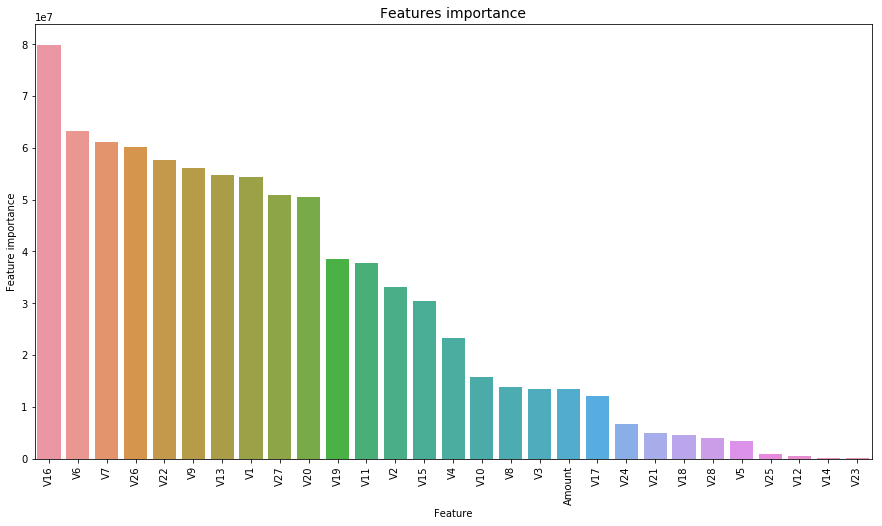

In [13]:
features = ['Amount', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28']
featureImportance = np.abs(lsvcModel.coefficients)
print(featureImportance)
tmp = pd.DataFrame({'Feature': features, 'Feature importance': featureImportance})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (15,8))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()

## 6) Build model with important features

removing V23

In [31]:
training = sqlContext.read.csv('base_train.csv', header = True)
testing = sqlContext.read.csv('base_test.csv', header = True)

training = training.select(*(col(c).cast("double").alias(c) for c in training.columns))
testing = testing.select(*(col(c).cast("double").alias(c) for c in testing.columns))

# Preparing training and test data for model building
vectorAssembler =VectorAssembler(inputCols=['V1','V2','V3','V4','V5','V6','V7','V8','V9',
                                            'V10','V11','V12','V13','V14','V15','V16','V17','V18',
                                            'V19','V20','V21','V22','V24','V25','V26','V27',
                                            'V28','Amount'],outputCol='features')

training_data = vectorAssembler.transform(training).select('features','Class')
testing_data = vectorAssembler.transform(testing).select('features','Class')

# Build Model
lsvc = LinearSVC(maxIter=100, regParam=0, standardization=True, tol=1e-6, threshold=0, aggregationDepth=2,
                 featuresCol = 'features', labelCol='Class')

# Fit the model on training data
lsvcModel  = lsvc.fit(training_data)
# Print the coefficients and intercept for linearsSVC
print("Coefficients: " + str(lsvcModel.coefficients))
print("\nIntercept: " + str(lsvcModel.intercept))

# Compute raw scores on the test set
print("EVALUATE PREDICTION ON TEST SET")
pred_results = lsvcModel.transform(testing_data)
pred_results.show(5)

# Convert to RDD and just incliding prediction and class to calculate metrics
predictionAndLabels = pred_results.select('Class','prediction').rdd.map(lambda lp: (float(lp.prediction), lp.Class))

# To print RDD
#print(predictionAndLabels.collect())

# Instantiate metrics object
metrics = MulticlassMetrics(predictionAndLabels)
print("Confusion Matrix:\n")
print(metrics.confusionMatrix().toArray())
print("\nOverall Evaluation:")
print("Accuracy = %s" % metrics.accuracy)
print("fMeasure = %s" % metrics.fMeasure())
print("precision = %s" % metrics.precision())
print("recall = %s" % metrics.recall())
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="Class",metricName="areaUnderPR")
print("Area under Precision Recall Curve = %s" % evaluator.evaluate(pred_results))
evaluator=  BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="Class",metricName="areaUnderROC")
print("Area under ROC = %s" % evaluator.evaluate(pred_results))

print("\nClass 1 Evaluation:")
print("fMeasure = %s" % metrics.fMeasure(1.0,1.0))
print("false positive rate = %s" % metrics.falsePositiveRate(1.0))
print("precision = %s" % metrics.precision(1.0))
print("recall = %s" % metrics.recall(1.0))

print("\nClass 0 Evaluation:")
print("fMeasure = %s" % metrics.fMeasure(0.0,0.0))
print("false positive rate = %s" % metrics.falsePositiveRate(0.0))
print("precision = %s" % metrics.precision(0.0))
print("recall = %s" % metrics.recall(0.0))

Coefficients: [0.05099865423787985,0.002003862235226928,-0.07053299340152917,0.36662655392739657,-0.10971957875384993,-0.05026650958168456,-0.1963272297449319,2.5013084938835877,-0.5453974309462307,-0.667497855756912,0.6590998173466558,-1.2714398137418057,-0.002511002479939006,-1.4646152190407913,-0.016002927192606188,-1.2432394971419478,-1.1917037625095137,-0.036804366456508794,0.0015370027749541735,0.002158590659681067,1.8116398343039055,-0.026520706075086775,-0.0020944072273670496,-0.029856932274003194,0.00015911545481921564,-0.1270264487030034,-0.09835248868238969,-0.0757163556349462]

Intercept: -4.618736584460154e-05
EVALUATE PREDICTION ON TEST SET
+--------------------+-----+--------------------+----------+
|            features|Class|       rawPrediction|prediction|
+--------------------+-----+--------------------+----------+
|[0.975813201,0.76...|  0.0|[1.20943260377264...|       0.0|
|[0.947109992,0.77...|  0.0|[1.18241062331554...|       0.0|
|[0.975559578,0.76...|  0.0|[1.1

removing v23 and v14

In [32]:
training = sqlContext.read.csv('base_train.csv', header = True)
testing = sqlContext.read.csv('base_test.csv', header = True)

training = training.select(*(col(c).cast("double").alias(c) for c in training.columns))
testing = testing.select(*(col(c).cast("double").alias(c) for c in testing.columns))

# Preparing training and test data for model building
vectorAssembler =VectorAssembler(inputCols=['V1','V2','V3','V4','V5','V6','V7','V8','V9',
                                            'V10','V11','V12','V13','V15','V16','V17','V18',
                                            'V19','V20','V21','V22', 'V24','V25','V26','V27',
                                            'V28','Amount'],outputCol='features')

training_data = vectorAssembler.transform(training).select('features','Class')
testing_data = vectorAssembler.transform(testing).select('features','Class')

# Build Model
lsvc = LinearSVC(maxIter=100, regParam=0, standardization=True, tol=1e-6, threshold=0, aggregationDepth=2,
                 featuresCol = 'features', labelCol='Class')

# Fit the model on training data
lsvcModel  = lsvc.fit(training_data)
# Print the coefficients and intercept for linearsSVC
print("Coefficients: " + str(lsvcModel.coefficients))
print("\nIntercept: " + str(lsvcModel.intercept))

# Compute raw scores on the test set
print("EVALUATE PREDICTION ON TEST SET")
pred_results = lsvcModel.transform(testing_data)
pred_results.show(5)

# Convert to RDD and just incliding prediction and class to calculate metrics
predictionAndLabels = pred_results.select('Class','prediction').rdd.map(lambda lp: (float(lp.prediction), lp.Class))

# To print RDD
#print(predictionAndLabels.collect())

# Instantiate metrics object
metrics = MulticlassMetrics(predictionAndLabels)
print("Confusion Matrix:\n")
print(metrics.confusionMatrix().toArray())
print("\nOverall Evaluation:")
print("Accuracy = %s" % metrics.accuracy)
print("fMeasure = %s" % metrics.fMeasure())
print("precision = %s" % metrics.precision())
print("recall = %s" % metrics.recall())
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="Class",metricName="areaUnderPR")
print("Area under Precision Recall Curve = %s" % evaluator.evaluate(pred_results))
evaluator=  BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="Class",metricName="areaUnderROC")
print("Area under ROC = %s" % evaluator.evaluate(pred_results))

print("\nClass 1 Evaluation:")
print("fMeasure = %s" % metrics.fMeasure(1.0,1.0))
print("false positive rate = %s" % metrics.falsePositiveRate(1.0))
print("precision = %s" % metrics.precision(1.0))
print("recall = %s" % metrics.recall(1.0))

print("\nClass 0 Evaluation:")
print("fMeasure = %s" % metrics.fMeasure(0.0,0.0))
print("false positive rate = %s" % metrics.falsePositiveRate(0.0))
print("precision = %s" % metrics.precision(0.0))
print("recall = %s" % metrics.recall(0.0))

Coefficients: [-26189280.614019055,41496728.03850582,-65625510.90336873,10156116.688992428,-44942573.88577605,-6256583.136698389,-123883552.0200343,47167431.39297619,-27360879.893494017,-111102592.72928017,11765922.604073223,-75034500.46012247,463529.88029086345,76787.69099621683,-60480462.29713582,-158397131.14935547,-23877415.891390823,3462738.523693147,29824683.712088402,39088194.28785363,3810934.222223596,76244.69190480285,5170661.250975474,709580.6723290663,46506567.25512824,39576662.32110057,3056423.300732567]

Intercept: 6835.458253570818
EVALUATE PREDICTION ON TEST SET
+--------------------+-----+--------------------+----------+
|            features|Class|       rawPrediction|prediction|
+--------------------+-----+--------------------+----------+
|[0.975813201,0.76...|  0.0|[3.06777306870819...|       0.0|
|[0.947109992,0.77...|  0.0|[3.07602216086396...|       0.0|
|[0.975559578,0.76...|  0.0|[3.06478413433465...|       0.0|
|[0.935329608,0.78...|  0.0|[3.01742181303230...| 

removing V25 

In [33]:
training = sqlContext.read.csv('base_train.csv', header = True)
testing = sqlContext.read.csv('base_test.csv', header = True)

training = training.select(*(col(c).cast("double").alias(c) for c in training.columns))
testing = testing.select(*(col(c).cast("double").alias(c) for c in testing.columns))

# Preparing training and test data for model building
vectorAssembler =VectorAssembler(inputCols=['V1','V2','V3','V4','V5','V6','V7','V8','V9',
                                            'V10','V11','V12','V13','V14','V15','V16','V17','V18',
                                            'V19','V20','V21','V22','V23','V24','V26','V27',
                                            'V28','Amount'],outputCol='features')

training_data = vectorAssembler.transform(training).select('features','Class')
testing_data = vectorAssembler.transform(testing).select('features','Class')

# Build Model
lsvc = LinearSVC(maxIter=100, regParam=0, standardization=True, tol=1e-6, threshold=0, aggregationDepth=2,
                 featuresCol = 'features', labelCol='Class')

# Fit the model on training data
lsvcModel  = lsvc.fit(training_data)
# Print the coefficients and intercept for linearsSVC
print("Coefficients: " + str(lsvcModel.coefficients))
print("\nIntercept: " + str(lsvcModel.intercept))

# Compute raw scores on the test set
print("EVALUATE PREDICTION ON TEST SET")
pred_results = lsvcModel.transform(testing_data)
pred_results.show(5)

# Convert to RDD and just incliding prediction and class to calculate metrics
predictionAndLabels = pred_results.select('Class','prediction').rdd.map(lambda lp: (float(lp.prediction), lp.Class))

# To print RDD
#print(predictionAndLabels.collect())

# Instantiate metrics object
metrics = MulticlassMetrics(predictionAndLabels)
print("Confusion Matrix:\n")
print(metrics.confusionMatrix().toArray())
print("\nOverall Evaluation:")
print("Accuracy = %s" % metrics.accuracy)
print("fMeasure = %s" % metrics.fMeasure())
print("precision = %s" % metrics.precision())
print("recall = %s" % metrics.recall())
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="Class",metricName="areaUnderPR")
print("Area under Precision Recall Curve = %s" % evaluator.evaluate(pred_results))
evaluator=  BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="Class",metricName="areaUnderROC")
print("Area under ROC = %s" % evaluator.evaluate(pred_results))

print("\nClass 1 Evaluation:")
print("fMeasure = %s" % metrics.fMeasure(1.0,1.0))
print("false positive rate = %s" % metrics.falsePositiveRate(1.0))
print("precision = %s" % metrics.precision(1.0))
print("recall = %s" % metrics.recall(1.0))

print("\nClass 0 Evaluation:")
print("fMeasure = %s" % metrics.fMeasure(0.0,0.0))
print("false positive rate = %s" % metrics.falsePositiveRate(0.0))
print("precision = %s" % metrics.precision(0.0))
print("recall = %s" % metrics.recall(0.0))

Coefficients: [0.3147691627105632,0.7245572117202671,0.006054552953975236,0.5616744309156111,0.0077907335308473585,-0.009030793781771887,-0.27335233372394224,0.7190123574838607,-1.0595889538827812,-1.059494649522429,1.287603129675375,-1.6680344786885717,-3.369462256117768e-05,-1.390640173768389,-0.0914953558778872,-1.6753328040358186,-1.8922634183994482,-0.07932891227798738,0.04280684498646152,0.40214983893047157,0.9188931353001322,0.0377567699673414,1.7389733276526342,0.0004751647049320766,0.16782217089434998,0.6006479631245139,0.5133492578879651,-0.5199676037163374]

Intercept: 8.552045004515997e-05
EVALUATE PREDICTION ON TEST SET
+--------------------+-----+--------------------+----------+
|            features|Class|       rawPrediction|prediction|
+--------------------+-----+--------------------+----------+
|[0.975813201,0.76...|  0.0|[1.32563603121761...|       0.0|
|[0.947109992,0.77...|  0.0|[1.28402734336647...|       0.0|
|[0.975559578,0.76...|  0.0|[1.22242515566000...|     

## 7) once important features are finalized, stratified cv grid search for marginal improvement

Not removing any features as performance drops with every feature removal

## 8) Use stratified cv to compare no sampling, undersampling, and oversampling

UnderSampling ratio =  0.01

In [4]:
df = sqlContext.read.csv("base_train.csv", header = True)
features = ['V1','V2','V3','V4','V5','V6','V7','V8','V9',
                                            'V10','V11','V12','V13','V14','V15','V16','V17','V18',
                                            'V19','V20','V21','V22','V23','V24','V25','V26','V27',
                                            'V28','Amount']

cv_hyper, cv_precision, cv_recall, cv_fscore = tune(df, 5, True, 'under', 0.01, False, features, 'svm', [100], [0], [1e-6])

print("gs precision:", cv_precision)
print("gs recall:", cv_recall)
print("gs f-score:", cv_fscore)
print("gs hyper:", cv_hyper)

[100, 0, 1e-06]
train: 24600
fraud ratio: 0.01
train: 24700
fraud ratio: 0.01
train: 24600
fraud ratio: 0.01
train: 24600
fraud ratio: 0.01
train: 24700
fraud ratio: 0.01
[0.5192261501411168, 0.8347964040190377, 0.6402376706040966]
gs precision: 0.5192261501411168
gs recall: 0.8347964040190377
gs f-score: 0.6402376706040966
gs hyper: [100, 0, 1e-06]


UnderSampling ratio = 0.05

In [5]:
df = sqlContext.read.csv("base_train.csv", header = True)
features = ['V1','V2','V3','V4','V5','V6','V7','V8','V9',
                                            'V10','V11','V12','V13','V14','V15','V16','V17','V18',
                                            'V19','V20','V21','V22','V23','V24','V25','V26','V27',
                                            'V28','Amount']

cv_hyper, cv_precision, cv_recall, cv_fscore = tune(df, 5, True, 'under', 0.05, False, features, 'svm', [100], [0], [1e-6])

print("gs precision:", cv_precision)
print("gs recall:", cv_recall)
print("gs f-score:", cv_fscore)
print("gs hyper:", cv_hyper)

[100, 0, 1e-06]
train: 4919
fraud ratio: 0.05001016466761537
train: 4919
fraud ratio: 0.05001016466761537
train: 4939
fraud ratio: 0.05001012350678275
train: 4919
fraud ratio: 0.05001016466761537
train: 4939
fraud ratio: 0.05001012350678275
[0.621932988335937, 0.686991010047594, 0.6528451955445479]
gs precision: 0.621932988335937
gs recall: 0.686991010047594
gs f-score: 0.6528451955445479
gs hyper: [100, 0, 1e-06]


UnderSampling ratio = 0.10

In [5]:
df = sqlContext.read.csv("base_train.csv", header = True)
features = ['V1','V2','V3','V4','V5','V6','V7','V8','V9',
                                            'V10','V11','V12','V13','V14','V15','V16','V17','V18',
                                            'V19','V20','V21','V22','V23','V24','V25','V26','V27',
                                            'V28','Amount']

cv_hyper, cv_precision, cv_recall, cv_fscore = tune(df, 5, True, 'under', 0.10, False, features, 'svm', [100], [0], [1e-6])

print("gs precision:", cv_precision)
print("gs recall:", cv_recall)
print("gs f-score:", cv_fscore)
print("gs hyper:", cv_hyper)

[100, 0, 1e-06]
train: 2460
fraud ratio: 0.1
train: 2460
fraud ratio: 0.1
train: 2460
fraud ratio: 0.1
train: 2470
fraud ratio: 0.1
train: 2470
fraud ratio: 0.1
train: 2460
fraud ratio: 0.1
train: 2470
fraud ratio: 0.1
[0.6732960323369854, 0.7340031729243787, 0.7023402304287654]
gs precision: 0.6732960323369854
gs recall: 0.7340031729243787
gs f-score: 0.7023402304287654
gs hyper: [100, 0, 1e-06]


UnderSampling ratio = 0.20

In [6]:
df = sqlContext.read.csv("base_train.csv", header = True)
features = ['V1','V2','V3','V4','V5','V6','V7','V8','V9',
                                            'V10','V11','V12','V13','V14','V15','V16','V17','V18',
                                            'V19','V20','V21','V22','V23','V24','V25','V26','V27',
                                            'V28','Amount']

cv_hyper, cv_precision, cv_recall, cv_fscore = tune(df, 5, True, 'under', 0.20, False, features, 'svm', [100], [0], [1e-6])

print("gs precision:", cv_precision)
print("gs recall:", cv_recall)
print("gs f-score:", cv_fscore)
print("gs hyper:", cv_hyper)

[100, 0, 1e-06]
train: 1235
fraud ratio: 0.2
train: 1230
fraud ratio: 0.2
train: 1230
fraud ratio: 0.2
train: 1230
fraud ratio: 0.2
train: 1235
fraud ratio: 0.2
[0.6662677082777867, 0.7206240084611316, 0.6923806680110621]
gs precision: 0.6662677082777867
gs recall: 0.7206240084611316
gs f-score: 0.6923806680110621
gs hyper: [100, 0, 1e-06]


UnderSampling ratio = 0.40

In [7]:
df = sqlContext.read.csv("base_train.csv", header = True)
features = ['V1','V2','V3','V4','V5','V6','V7','V8','V9',
                                            'V10','V11','V12','V13','V14','V15','V16','V17','V18',
                                            'V19','V20','V21','V22','V23','V24','V25','V26','V27',
                                            'V28','Amount']

cv_hyper, cv_precision, cv_recall, cv_fscore = tune(df, 5, True, 'under', 0.40, False, features, 'svm', [100], [0], [1e-6])

print("gs precision:", cv_precision)
print("gs recall:", cv_recall)
print("gs f-score:", cv_fscore)
print("gs hyper:", cv_hyper)

[100, 0, 1e-06]
train: 617
fraud ratio: 0.40032414910858993
train: 614
fraud ratio: 0.4006514657980456
train: 614
fraud ratio: 0.4006514657980456
train: 614
fraud ratio: 0.4006514657980456
train: 617
fraud ratio: 0.40032414910858993
[0.04531282915525595, 0.344632469592808, 0.08009468131119703]
gs precision: 0.04531282915525595
gs recall: 0.344632469592808
gs f-score: 0.08009468131119703
gs hyper: [100, 0, 1e-06]


UnderSampling ratio = 0.50

In [8]:
df = sqlContext.read.csv("base_train.csv", header = True)
features = ['V1','V2','V3','V4','V5','V6','V7','V8','V9',
                                            'V10','V11','V12','V13','V14','V15','V16','V17','V18',
                                            'V19','V20','V21','V22','V23','V24','V25','V26','V27',
                                            'V28','Amount']

cv_hyper, cv_precision, cv_recall, cv_fscore = tune(df, 5, True, 'under', 0.50, False, features, 'svm', [100], [0], [1e-6])

print("gs precision:", cv_precision)
print("gs recall:", cv_recall)
print("gs f-score:", cv_fscore)
print("gs hyper:", cv_hyper)

[100, 0, 1e-06]
train: 494
fraud ratio: 0.5
train: 492
fraud ratio: 0.5
train: 492
fraud ratio: 0.5
train: 492
fraud ratio: 0.5
train: 494
fraud ratio: 0.5
[0.12790657414053147, 0.8573241671073506, 0.22260246772993486]
gs precision: 0.12790657414053147
gs recall: 0.8573241671073506
gs f-score: 0.22260246772993486
gs hyper: [100, 0, 1e-06]


OverSampling ratio = 0.01

In [9]:
df = sqlContext.read.csv("base_train.csv", header = True)
features = ['V1','V2','V3','V4','V5','V6','V7','V8','V9',
                                            'V10','V11','V12','V13','V14','V15','V16','V17','V18',
                                            'V19','V20','V21','V22','V23','V24','V25','V26','V27',
                                            'V28','Amount']

cv_hyper, cv_precision, cv_recall, cv_fscore = tune(df, 5, True, 'over', 0.01, False, features, 'svm', [100], [0], [1e-6])

print("gs precision:", cv_precision)
print("gs recall:", cv_recall)
print("gs f-score:", cv_fscore)
print("gs hyper:", cv_hyper)

[100, 0, 1e-06]
train: 146485
fraud ratio: 0.009994197358091272
train: 146484
fraud ratio: 0.009994265585319899
train: 146484
fraud ratio: 0.009994265585319899
train: 146484
fraud ratio: 0.009994265585319899
train: 146487
fraud ratio: 0.009994060906428556
[0.16802689222644868, 0.9475409836065574, 0.2854373457351784]
gs precision: 0.16802689222644868
gs recall: 0.9475409836065574
gs f-score: 0.2854373457351784
gs hyper: [100, 0, 1e-06]


OverSampling ratio = 0.05

In [10]:
df = sqlContext.read.csv("base_train.csv", header = True)
features = ['V1','V2','V3','V4','V5','V6','V7','V8','V9',
                                            'V10','V11','V12','V13','V14','V15','V16','V17','V18',
                                            'V19','V20','V21','V22','V23','V24','V25','V26','V27',
                                            'V28','Amount']

cv_hyper, cv_precision, cv_recall, cv_fscore = tune(df, 5, True, 'over', 0.05, False, features, 'svm', [100], [0], [1e-6])

print("gs precision:", cv_precision)
print("gs recall:", cv_recall)
print("gs f-score:", cv_fscore)
print("gs hyper:", cv_hyper)

[100, 0, 1e-06]
train: 152653
fraud ratio: 0.04999574197690186
train: 152652
fraud ratio: 0.04999606949139219
train: 152652
fraud ratio: 0.04999606949139219
train: 152652
fraud ratio: 0.04999606949139219
train: 152655
fraud ratio: 0.049995086960793945
[0.5469106172103838, 0.6539397144368059, 0.5956555341087958]
gs precision: 0.5469106172103838
gs recall: 0.6539397144368059
gs f-score: 0.5956555341087958
gs hyper: [100, 0, 1e-06]


OverSampling ratio = 0.10

In [11]:
df = sqlContext.read.csv("base_train.csv", header = True)
features = ['V1','V2','V3','V4','V5','V6','V7','V8','V9',
                                            'V10','V11','V12','V13','V14','V15','V16','V17','V18',
                                            'V19','V20','V21','V22','V23','V24','V25','V26','V27',
                                            'V28','Amount']

cv_hyper, cv_precision, cv_recall, cv_fscore = tune(df, 5, True, 'over', 0.10, False, features, 'svm', [100], [0], [1e-6])

print("gs precision:", cv_precision)
print("gs recall:", cv_recall)
print("gs f-score:", cv_fscore)
print("gs hyper:", cv_hyper)

[100, 0, 1e-06]
train: 161133
fraud ratio: 0.09999813818398466
train: 161133
fraud ratio: 0.09999813818398466
train: 161134
fraud ratio: 0.09999751759405215
train: 161133
fraud ratio: 0.09999813818398466
train: 161136
fraud ratio: 0.09999627643729521
[0.3408762161363902, 0.6438921205711263, 0.4457647580224978]
gs precision: 0.3408762161363902
gs recall: 0.6438921205711263
gs f-score: 0.4457647580224978
gs hyper: [100, 0, 1e-06]


OverSampling ratio = 0.20

In [12]:
df = sqlContext.read.csv("base_train.csv", header = True)
features = ['V1','V2','V3','V4','V5','V6','V7','V8','V9',
                                            'V10','V11','V12','V13','V14','V15','V16','V17','V18',
                                            'V19','V20','V21','V22','V23','V24','V25','V26','V27',
                                            'V28','Amount']

cv_hyper, cv_precision, cv_recall, cv_fscore = tune(df, 5, True, 'over', 0.20, False, features, 'svm', [100], [0], [1e-6])

print("gs precision:", cv_precision)
print("gs recall:", cv_recall)
print("gs f-score:", cv_fscore)
print("gs hyper:", cv_hyper)

[100, 0, 1e-06]
train: 181276
fraud ratio: 0.1999988967099892
train: 181275
fraud ratio: 0.2
train: 181275
fraud ratio: 0.2
train: 181275
fraud ratio: 0.2
train: 181278
fraud ratio: 0.19999669016648464
[0.5510785611216757, 0.7463775780010576, 0.6340294200872341]
gs precision: 0.5510785611216757
gs recall: 0.7463775780010576
gs f-score: 0.6340294200872341
gs hyper: [100, 0, 1e-06]


OverSampling ratio = 0.40

In [13]:
df = sqlContext.read.csv("base_train.csv", header = True)
features = ['V1','V2','V3','V4','V5','V6','V7','V8','V9',
                                            'V10','V11','V12','V13','V14','V15','V16','V17','V18',
                                            'V19','V20','V21','V22','V23','V24','V25','V26','V27',
                                            'V28','Amount']

cv_hyper, cv_precision, cv_recall, cv_fscore = tune(df, 5, True, 'over', 0.40, False, features, 'svm', [100], [0], [1e-6])

print("gs precision:", cv_precision)
print("gs recall:", cv_recall)
print("gs f-score:", cv_fscore)
print("gs hyper:", cv_hyper)

[100, 0, 1e-06]
train: 241700
fraud ratio: 0.4
train: 241700
fraud ratio: 0.4
train: 241701
fraud ratio: 0.39999834506270143
train: 241700
fraud ratio: 0.4
train: 241705
fraud ratio: 0.4
[0.04190767734228627, 0.5222104706504495, 0.07758881002730762]
gs precision: 0.04190767734228627
gs recall: 0.5222104706504495
gs f-score: 0.07758881002730762
gs hyper: [100, 0, 1e-06]


OverSampling ratio = 0.50

In [14]:
df = sqlContext.read.csv("base_train.csv", header = True)
features = ['V1','V2','V3','V4','V5','V6','V7','V8','V9',
                                            'V10','V11','V12','V13','V14','V15','V16','V17','V18',
                                            'V19','V20','V21','V22','V23','V24','V25','V26','V27',
                                            'V28','Amount']

cv_hyper, cv_precision, cv_recall, cv_fscore = tune(df, 5, True, 'over', 0.50, False, features, 'svm', [100], [0], [1e-6])

print("gs precision:", cv_precision)
print("gs recall:", cv_recall)
print("gs f-score:", cv_fscore)
print("gs hyper:", cv_hyper)

[100, 0, 1e-06]
train: 290040
fraud ratio: 0.5
train: 290042
fraud ratio: 0.5
train: 290040
fraud ratio: 0.5
train: 290040
fraud ratio: 0.5
train: 290046
fraud ratio: 0.5
[0.0581038083630286, 0.8735060814383925, 0.10895983504566481]
gs precision: 0.0581038083630286
gs recall: 0.8735060814383925
gs f-score: 0.10895983504566481
gs hyper: [100, 0, 1e-06]


## 9) train base_train test base_test using hyperparams from 7)

In [15]:
# sampling function-based
def sample(df, sampling_method, ratio):

    notfraud = df.select('*').where(df.Class == 0.0)
    fraud = df.select('*').where(df.Class == 1.0)

    if sampling_method == "over":
        nrows = notfraud.select("Class").count()
        sample_size = int(nrows*ratio/(1-ratio))
        sampled = fraud.rdd.takeSample(True, sample_size, 46)
        fraud = sqlContext.createDataFrame(sampled)

    elif sampling_method == "under":
        nrows = fraud.select("Class").count()
        sample_size = int(nrows*(1-ratio)/ratio)
        sampled = notfraud.rdd.takeSample(False, sample_size, 46)
        notfraud = sqlContext.createDataFrame(sampled)

    sampled = fraud.union(notfraud)
    fraud_count = sampled.select("Class").where(sampled.Class == 1.0).count()
    tot_count = sampled.select("Class").count()
    fraud_ratio = fraud_count / tot_count

    print("train after sampling: " + str(tot_count))
    print("fraud ratio: " + str(fraud_ratio))

    #shuffle undersampled dataframe
    nrows = sampled.select("Class").count()
    shuffled = sampled.rdd.takeSample(False, nrows)
    shuffled_df = sqlContext.createDataFrame(shuffled)

    return shuffled_df

In [26]:
df = sqlContext.read.csv("base_train.csv", header = True)
training = sample(df, 'under', 0.10)
testing = sqlContext.read.csv('base_test.csv', header = True)

training = training.select(*(col(c).cast("double").alias(c) for c in training.columns))
testing = testing.select(*(col(c).cast("double").alias(c) for c in testing.columns))

# Preparing training and test data for model building
vectorAssembler =VectorAssembler(inputCols=['V1','V2','V3','V4','V5','V6','V7','V8','V9',
                                            'V10','V11','V12','V13','V14','V15','V16','V17','V18',
                                            'V19','V20','V21','V22','V23','V24','V25','V26','V27',
                                            'V28','Amount'],outputCol='features')

training_data = vectorAssembler.transform(training).select('features','Class')
testing_data = vectorAssembler.transform(testing).select('features','Class')

# Build Model
lsvc = LinearSVC(maxIter=100, regParam=0, standardization=True, tol=1e-6, threshold=0, aggregationDepth=2,
                 featuresCol = 'features', labelCol='Class')

# Fit the model on training data
lsvcModel  = lsvc.fit(training_data)
# Print the coefficients and intercept for linearsSVC
print("Coefficients: " + str(lsvcModel.coefficients))
print("\nIntercept: " + str(lsvcModel.intercept))

# Compute raw scores on the test set
print("EVALUATE PREDICTION ON TEST SET")
pred_results = lsvcModel.transform(testing_data)
pred_results.show(5)

# Convert to RDD and just incliding prediction and class to calculate metrics
predictionAndLabels = pred_results.select('Class','prediction').rdd.map(lambda lp: (float(lp.prediction), lp.Class))

# To print RDD
#print(predictionAndLabels.collect())

# Instantiate metrics object
metrics = MulticlassMetrics(predictionAndLabels)
print("Confusion Matrix:\n")
print(metrics.confusionMatrix().toArray())
print("\nOverall Evaluation:")
print("Accuracy = %s" % metrics.accuracy)
print("fMeasure = %s" % metrics.fMeasure())
print("precision = %s" % metrics.precision())
print("recall = %s" % metrics.recall())
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="Class",metricName="areaUnderPR")
print("Area under Precision Recall Curve = %s" % evaluator.evaluate(pred_results))
evaluator=  BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="Class",metricName="areaUnderROC")
print("Area under ROC = %s" % evaluator.evaluate(pred_results))

print("\nClass 1 Evaluation:")
print("fMeasure = %s" % metrics.fMeasure(1.0,1.0))
print("false positive rate = %s" % metrics.falsePositiveRate(1.0))
print("precision = %s" % metrics.precision(1.0))
print("recall = %s" % metrics.recall(1.0))

print("\nClass 0 Evaluation:")
print("fMeasure = %s" % metrics.fMeasure(0.0,0.0))
print("false positive rate = %s" % metrics.falsePositiveRate(0.0))
print("precision = %s" % metrics.precision(0.0))
print("recall = %s" % metrics.recall(0.0))

train after sampling: 3079
fraud ratio: 0.10003247807729783
Coefficients: [-0.04749698507864312,-0.01064948165990448,-0.3348078659736613,4.185215838234029,-0.2002936576223215,-0.05546262795000344,-0.6885729392962682,-0.0900824587440696,-0.4353796545090049,-0.6538890286760872,7.223975245027507,-0.9198661304009559,-0.006514236498155325,-1.5045674016375015,-0.003457317905492695,-0.9380861651011605,-0.8822007153616107,-0.496352241120324,0.007625931666285767,-0.09801540259589066,-0.024122262020219668,-0.017363985432215862,-0.21880235435461257,-0.0002601401709577144,-0.034488042084791774,-0.00270021991534686,-0.11810219721848411,-0.27961141511035426,-2.6104743167647197]

Intercept: -5.71821797729421e-05
EVALUATE PREDICTION ON TEST SET
+--------------------+-----+--------------------+----------+
|            features|Class|       rawPrediction|prediction|
+--------------------+-----+--------------------+----------+
|[0.975813201,0.76...|  0.0|[1.94503678431869...|       0.0|
|[0.947109992,0.7

## 10) train base_train test oot using hyperparams from 8)

In [27]:
testing = sqlContext.read.csv('oot.csv', header = True)
testing = testing.select(*(col(c).cast("double").alias(c) for c in testing.columns))
# Preparing training and test data for model building
vectorAssembler =VectorAssembler(inputCols=['V1','V2','V3','V4','V5','V6','V7','V8','V9',
                                            'V10','V11','V12','V13','V14','V15','V16','V17','V18',
                                            'V19','V20','V21','V22','V23','V24','V25','V26','V27',
                                            'V28','Amount'],outputCol='features')
testing_data = vectorAssembler.transform(testing).select('features','Class')
# Compute raw scores on the test set
print("EVALUATE PREDICTION ON TEST SET")
pred_results = lsvcModel.transform(testing_data)
pred_results.show(5)

# Convert to RDD and just incliding prediction and class to calculate metrics
predictionAndLabels = pred_results.select('Class','prediction').rdd.map(lambda lp: (float(lp.prediction), lp.Class))

# To print RDD
#print(predictionAndLabels.collect())

# Instantiate metrics object
metrics = MulticlassMetrics(predictionAndLabels)
print("Confusion Matrix:\n")
print(metrics.confusionMatrix().toArray())
print("\nOverall Evaluation:")
print("Accuracy = %s" % metrics.accuracy)
print("fMeasure = %s" % metrics.fMeasure())
print("precision = %s" % metrics.precision())
print("recall = %s" % metrics.recall())
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="Class",metricName="areaUnderPR")
print("Area under Precision Recall Curve = %s" % evaluator.evaluate(pred_results))
evaluator=  BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="Class",metricName="areaUnderROC")
print("Area under ROC = %s" % evaluator.evaluate(pred_results))

print("\nClass 1 Evaluation:")
print("fMeasure = %s" % metrics.fMeasure(1.0,1.0))
print("false positive rate = %s" % metrics.falsePositiveRate(1.0))
print("precision = %s" % metrics.precision(1.0))
print("recall = %s" % metrics.recall(1.0))

print("\nClass 0 Evaluation:")
print("fMeasure = %s" % metrics.fMeasure(0.0,0.0))
print("false positive rate = %s" % metrics.falsePositiveRate(0.0))
print("precision = %s" % metrics.precision(0.0))
print("recall = %s" % metrics.recall(0.0))

EVALUATE PREDICTION ON TEST SET
+--------------------+-----+--------------------+----------+
|            features|Class|       rawPrediction|prediction|
+--------------------+-----+--------------------+----------+
|[0.99380842121992...|  0.0|[2.34682596842262...|       0.0|
|[0.96072303825523...|  0.0|[2.19614890771865...|       0.0|
|[0.99248737657781...|  0.0|[1.20905331550666...|       0.0|
|[0.92658813030988...|  0.0|[0.70187605896471...|       0.0|
|[0.99344967061734...|  0.0|[2.10630661321926...|       0.0|
+--------------------+-----+--------------------+----------+
only showing top 5 rows

Confusion Matrix:

[[5.6652e+04 2.0000e+01]
 [2.6000e+01 4.8000e+01]]

Overall Evaluation:
Accuracy = 0.9991893701758714
fMeasure = 0.9991893701758714
precision = 0.9991893701758714
recall = 0.9991893701758714
Area under Precision Recall Curve = 0.7079254026104055
Area under ROC = 0.9588084873411391

Class 1 Evaluation:
fMeasure = 0.676056338028169
false positive rate = 0.0003529079616036137